In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


In [34]:
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)

from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv("./lstm_nakayama_daily_merge_label.csv") 
df.head(n=5)  # visualize the data.df = pd.read_csv("data/processminer-rare-event-mts - data.csv") 


,datetime,transdiff,stepdifcc,Acc,AccStd,movavgacc,movavgstep,movavgtrans,movstdacc,movstdstep,...,stepCount,dist,dist2,movavgdist1,movavgdist2,movstddist1,movstddist2,label,predictedcalving,days
0,2019/05/02,1939.0,4432.0,1.089342,0.218972,1.089342,4432.00000,1939.000000,NaN,NaN,...,3631.0,156097.4593,33.758101,156097.4593,33.758101,NaN,NaN,0.0,22.0,16
1,2019/05/03,6680.0,16138.0,1.125734,0.209822,1.107538,10285.00000,4309.500000,0.025733,8277.391981,...,16014.0,465637.0222,24.767927,310867.2408,29.263014,218877.5240,6.357013,0.0,21.0,15
2,2019/05/04,4305.0,9927.0,1.094155,0.172960,1.103077,10165.66667,4308.000000,0.019768,5856.648387,...,9848.0,313763.0113,26.651067,311832.4976,28.392365,154778.8113,4.741297,0.0,20.0,14
3,2019/05/05,4188.0,10258.0,1.093453,0.191864,1.100671,12107.66667,5057.666667,0.016843,3494.292537,...,10186.0,307003.4594,25.641315,310625.2381,27.704602,126399.4337,4.108366,0.0,19.0,13
4,2019/05/06,5590.0,13838.0,1.125411,0.218175,1.105619,11341.00000,4694.333333,0.018308,2168.789294,...,13740.0,436475.1339,27.397849,335795.2172,27.643252,123086.3595,3.560593,0.0,18.0,12


In [4]:
# Shift label 

sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):

    vector = df['label'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'label'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['label'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 2-hour ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))

Before shifting


,datetime,transdiff,stepdifcc,Acc,AccStd
13,2019/05/15,5288.0,10502.0,1.095779,0.178576
14,2019/05/16,3830.0,7686.0,1.073012,0.159100
15,2019/05/17,5055.0,9455.0,1.086423,0.173224
16,2019/05/18,2131.0,3763.0,1.055425,0.149381
17,2019/04/15,1657.0,2730.0,1.335216,0.394488


After shifting


,label,datetime,transdiff,stepdifcc,Acc
12,0.0,2019/05/14,4430.0,9389.0,1.084683
13,0.0,2019/05/15,5288.0,10502.0,1.095779
14,1.0,2019/05/16,3830.0,7686.0,1.073012
15,1.0,2019/05/17,5055.0,9455.0,1.086423
17,0.0,2019/04/15,1657.0,2730.0,1.335216


In [6]:
# Remove time column, and the categorical columns
df = df.drop(['datetime'], axis=1)
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 1 to 714
Data columns (total 20 columns):
label               639 non-null float64
transdiff           639 non-null float64
stepdifcc           639 non-null float64
Acc                 639 non-null float64
AccStd              639 non-null float64
movavgacc           639 non-null float64
movavgstep          639 non-null float64
movavgtrans         639 non-null float64
movstdacc           639 non-null float64
movstdstep          639 non-null float64
movstdtrans         639 non-null float64
stepCount           639 non-null float64
dist                639 non-null float64
dist2               639 non-null float64
movavgdist1         639 non-null float64
movavgdist2         639 non-null float64
movstddist1         639 non-null float64
movstddist2         639 non-null float64
predictedcalving    639 non-null float64
days                639 non-null int64
dtypes: float64(19), int64(1)
memory usage: 104.8 KB


In [8]:
input_X = df.loc[:, df.columns != 'label'].values  # converts the df to a numpy array
input_y = df['label'].values

n_features = input_X.shape[1]  # number of features

In [9]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [10]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 4
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))

First instance of y = 1 in the original data


,label,transdiff,stepdifcc,Acc,AccStd,movavgacc,movavgstep,movavgtrans,movstdacc,movstdstep,movstdtrans,stepCount,dist,dist2,movavgdist1,movavgdist2,movstddist1,movstddist2,predictedcalving,days
9,0.0,5456.0,12390.0,1.100431,0.182507,1.089587,10793.666670,4955.333333,0.011380,2258.936107,913.463920,12279.0,368213.3872,24.835653,337798.9033,25.820318,44663.90258,1.020550,13.0,7
10,0.0,3861.0,7865.0,1.083267,0.171349,1.088693,10679.000000,4942.000000,0.011732,2455.883344,936.548450,7829.0,279945.7497,28.343196,330432.5550,26.501906,51510.26340,1.362430,12.0,6
11,0.0,5451.0,13348.0,1.098084,0.197502,1.091087,11201.000000,4922.666667,0.012282,2928.500128,919.433702,13259.0,416913.8366,26.804284,344661.3828,26.753118,64893.59627,1.254118,11.0,5
12,0.0,4430.0,9389.0,1.084683,0.175276,1.093378,10200.666670,4580.666667,0.008651,2830.180972,805.636601,9347.0,317442.2477,27.656582,353638.5828,26.876036,54734.57672,1.318001,10.0,4
13,0.0,5288.0,10502.0,1.095779,0.178576,1.092449,11079.666670,5056.333333,0.007924,2041.738067,548.509192,10421.0,348061.0532,26.616277,346115.2549,26.851198,51732.72055,1.322357,9.0,3
14,1.0,3830.0,7686.0,1.073012,0.159100,1.086965,9192.333333,4516.000000,0.010184,1418.263845,732.794651,7616.0,254192.9985,26.745896,323311.1772,27.233247,63376.53638,0.743870,8.0,2


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3861.0,7865.0,1.083267,0.171349,1.088693,10679.000000,4942.000000,0.011732,2455.883344,936.548450,7829.0,279945.7497,28.343196,330432.5550,26.501906,51510.26340,1.362430,12.0,6.0
1,5451.0,13348.0,1.098084,0.197502,1.091087,11201.000000,4922.666667,0.012282,2928.500128,919.433702,13259.0,416913.8366,26.804284,344661.3828,26.753118,64893.59627,1.254118,11.0,5.0
2,4430.0,9389.0,1.084683,0.175276,1.093378,10200.666670,4580.666667,0.008651,2830.180972,805.636601,9347.0,317442.2477,27.656582,353638.5828,26.876036,54734.57672,1.318001,10.0,4.0
3,5288.0,10502.0,1.095779,0.178576,1.092449,11079.666670,5056.333333,0.007924,2041.738067,548.509192,10421.0,348061.0532,26.616277,346115.2549,26.851198,51732.72055,1.322357,9.0,3.0
4,3830.0,7686.0,1.073012,0.159100,1.086965,9192.333333,4516.000000,0.010184,1418.263845,732.794651,7616.0,254192.9985,26.745896,323311.1772,27.233247,63376.53638,0.743870,8.0,2.0


In [11]:
SEED = 150 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [12]:
X_train.shape

(404, 5, 1, 19)

In [13]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [14]:

X_train_y0.shape

(358, 5, 1, 19)

In [15]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [16]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [17]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [18]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [19]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0. -0.  0.  0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0.
 -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

In [21]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 50
batch = 10
lr = 0.0001

In [22]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             6656      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 19)             627       
Total params: 18,803
Trainable params: 18,803
Non-trainable params: 0


In [23]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Instructions for updating:
Use tf.cast instead.
Train on 358 samples, validate on 91 samples
Epoch 1/50
 - 4s - loss: 0.9504 - val_loss: 0.9429
Epoch 2/50
 - 1s - loss: 0.9498 - val_loss: 0.9422
Epoch 3/50
 - 1s - loss: 0.9490 - val_loss: 0.9411
Epoch 4/50
 - 1s - loss: 0.9478 - val_loss: 0.9390
Epoch 5/50
 - 1s - loss: 0.9452 - val_loss: 0.9341
Epoch 6/50
 - 1s - loss: 0.9386 - val_loss: 0.9201
Epoch 7/50
 - 1s - loss: 0.9245 - val_loss: 0.9054
Epoch 8/50
 - 1s - loss: 0.9147 - val_loss: 0.8934
Epoch 9/50
 - 1s - loss: 0.9044 - val_loss: 0.8807
Epoch 10/50
 - 1s - loss: 0.8890 - val_loss: 0.8631
Epoch 11/50
 - 1s - loss: 0.8705 - val_loss: 0.8465
Epoch 12/50
 - 1s - loss: 0.8526 - val_loss: 0.8260
Epoch 13/50
 - 1s - loss: 0.8345 - val_loss: 0.8079
Epoch 14/50
 - 1s - loss: 0.8172 - val_loss: 0.7886
Epoch 15/50
 - 1s - loss: 0.7988 - val_loss: 0.7668
Epoch 16/50
 - 1s - loss: 0.7799 - val_loss: 0.7471
Epoch 17/50
 - 1s - loss: 0.7572 - val_loss: 0.7303
Epoch 18/50
 - 1s - loss: 0.7377

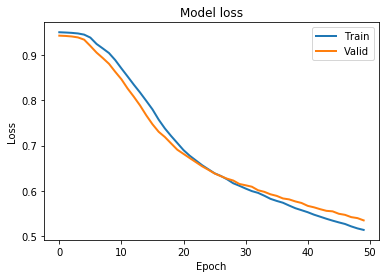

"\n# Plot accuracy\nplt.plot(lstm_autoencoder_history['acc'], linewidth=2, label='Train')\nplt.plot(lstm_autoencoder_history['val_acc'], linewidth=2, label='Valid')\nplt.legend(loc='upper right')\nplt.title('Model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.show()\n"

In [25]:
# Plot model loss
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


'''
# Plot accuracy
plt.plot(lstm_autoencoder_history['acc'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_acc'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
'''

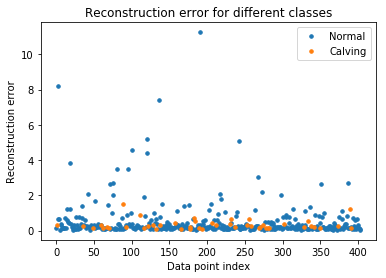

In [26]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Calving" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

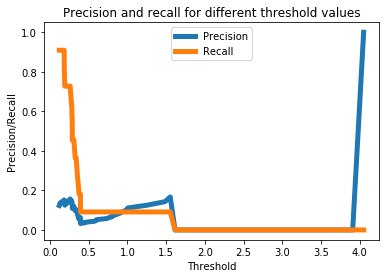

In [27]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

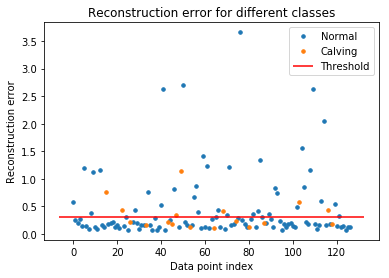

In [28]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Calving" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [29]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

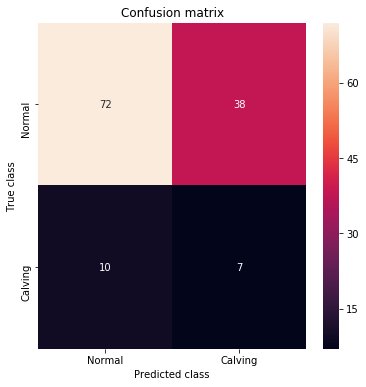

In [30]:
LABELS = ["Normal","Calving"]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

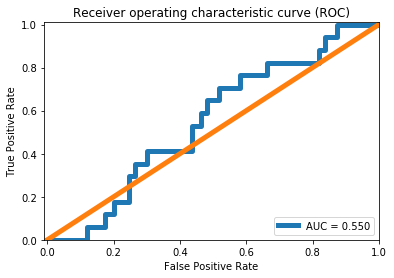

In [31]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score

precision_test = precision_score(error_df.True_class, pred_y)
recall_test = recall_score(error_df.True_class, pred_y)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.15555555555555556 
 Recall:  0.4117647058823529 
 F1-score: 0.22580645161290322
